# Klausurleistung DASC, Georg Kresse und Till Wollschläger

### A1 - Auswahl Datensatz

**Datensatz 2: Vorhersage eines Erkrankungsverlaufs** Menschen mit einer kardiovaskulären Erkrankung oder einem hohen kardiovaskulären Risiko benötigen eine frühzeitige Erkennung und Behandlung, bei der ein maschinelles Lernmodell eine große Hilfe sein kann. Mit welcher Genauigkeit lässt sich aus charakteristischen Patientendaten der tödliche Ausgang einer kardiovaskulären Erkrankung vorhersagen? Welche Merkmale sind die stärksten Einflussfaktoren?

### A2 - Skript- und Datenvorbereitung

##### Einbindung der grundlegenden Python-Bibliotheken

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

##### Datensatz einlesen und Überblick verschaffen

In [2]:
# Einlesen der Daten
df = pd.read_csv('heart_failure_clinical_dataset.csv')
df.head()

,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,time,DEATH_EVENT
0,75.0,0,582,0,20,1,265000.00,1.9,130,1,0,4,1
1,55.0,0,7861,0,38,0,263358.03,1.1,136,1,0,6,1
2,65.0,0,146,0,20,0,162000.00,1.3,129,1,1,7,1
3,50.0,1,111,0,20,0,210000.00,1.9,137,1,0,7,1
4,65.0,1,160,1,20,0,327000.00,2.7,116,0,0,8,1


In [3]:
print("Die Daten enthalten {} Zeilen und {} Spalten".format(df.shape[0], df.shape[1]))

Die Daten enthalten 299 Zeilen und 13 Spalten


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 299 entries, 0 to 298
Data columns (total 13 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   age                       299 non-null    float64
 1   anaemia                   299 non-null    int64  
 2   creatinine_phosphokinase  299 non-null    int64  
 3   diabetes                  299 non-null    int64  
 4   ejection_fraction         299 non-null    int64  
 5   high_blood_pressure       299 non-null    int64  
 6   platelets                 299 non-null    float64
 7   serum_creatinine          299 non-null    float64
 8   serum_sodium              299 non-null    int64  
 9   sex                       299 non-null    int64  
 10  smoking                   299 non-null    int64  
 11  time                      299 non-null    int64  
 12  DEATH_EVENT               299 non-null    int64  
dtypes: float64(3), int64(10)
memory usage: 30.5 KB


##### Metadaten-Informationen zusammenstellen
- https://archive.ics.uci.edu/dataset/519/heart+failure+clinical+records
- medizinische Informationen von 299 Patienten mit Herzversagen vom Faisalabad Insitute of Cardiology und dem alliierten Krankenhaus in Faisalabad (Punjab, Pakistan) im Zeitraum von April bis Dezember 2015
- 105 Frauen und 194 Männer, zwischen 40 und 95 Jahren alt
- alle Patienten hatten eine linke ventrikuläre systolische Dysfunktion und vorheriges Herzversagen (-> sind alle in Klasse III oder IV der New York Heart Association Klassifizierung für die Phasen des Herzversagens)
- https://bmcmedinformdecismak.biomedcentral.com/articles/10.1186/s12911-020-1023-5

##### Datenqualität beurteilen

In [5]:
# Duplikate ausgeben
print(f'Duplikate: {df.duplicated().sum()}')

Duplikate: 0


In [6]:
# Fehlende Daten ausgeben
print("Fehlende Daten:")
df.isna().sum()

Fehlende Daten:


age                         0
anaemia                     0
creatinine_phosphokinase    0
diabetes                    0
ejection_fraction           0
high_blood_pressure         0
platelets                   0
serum_creatinine            0
serum_sodium                0
sex                         0
smoking                     0
time                        0
DEATH_EVENT                 0
dtype: int64

##### Bereinigung des Datensatzes



In [7]:
# Fehlende und doppelte Daten entfernen
df = df.dropna()
df = df.drop_duplicates()

In [8]:
# Interquartilabstand -> bietet Robustheit bei Ausreißern
Q1 = df.quantile(0.25)
Q3 = df.quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
df = df[~((df < lower_bound) | (df > upper_bound)).any(axis=1)]

##### Bereinigung des Datensatzes

- Time ist kein Feature sondern eine Zielvariable (siehe https://www.kaggle.com/datasets/rabieelkharoua/predict-survival-of-patients-with-heart-failure/discussion/498685)
- die "time" Variable korreliert direkt mit "DEATH_EVENT" und könnte das Modell unbeabsichtigt beeinflussen
- es ist wichtig sicherzustellen, dass das Modell seine Entscheidungen anhand der klinischen Merkmale trifft

In [9]:
df = df.drop(columns=["time"])

##### Festlegung der abhängigen Zielvariable inklusive der Formulierung der Fragestellung

- Zielvariable: DEATH_EVENT
- Fragestellung: Überlebt die Person trotz der fortgeschrittenen Herzerkrankung?

### A3 - EDA

In [10]:
# Übersicht über den Datensatz
df.describe()

,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,DEATH_EVENT
count,224.000000,224.00000,224.000000,224.000000,224.000000,224.000000,224.000000,224.000000,224.000000,224.000000,224.000000,224.000000
mean,60.809527,0.46875,336.941964,0.419643,38.178571,0.379464,255865.190045,1.128571,137.044643,0.642857,0.321429,0.272321
std,11.946085,0.50014,279.521085,0.494606,11.710801,0.486340,67153.749051,0.327794,3.806740,0.480231,0.468071,0.446151
min,40.000000,0.00000,30.000000,0.000000,14.000000,0.000000,122000.000000,0.600000,125.000000,0.000000,0.000000,0.000000
25%,50.000000,0.00000,114.500000,0.000000,30.000000,0.000000,210000.000000,0.900000,134.000000,0.000000,0.000000,0.000000
50%,60.000000,0.00000,212.000000,0.000000,38.000000,0.000000,262500.000000,1.100000,137.000000,1.000000,0.000000,0.000000
75%,70.000000,1.00000,582.000000,1.000000,45.000000,1.000000,297250.000000,1.300000,140.000000,1.000000,1.000000,1.000000
max,95.000000,1.00000,1202.000000,1.000000,65.000000,1.000000,427000.000000,2.100000,148.000000,1.000000,1.000000,1.000000


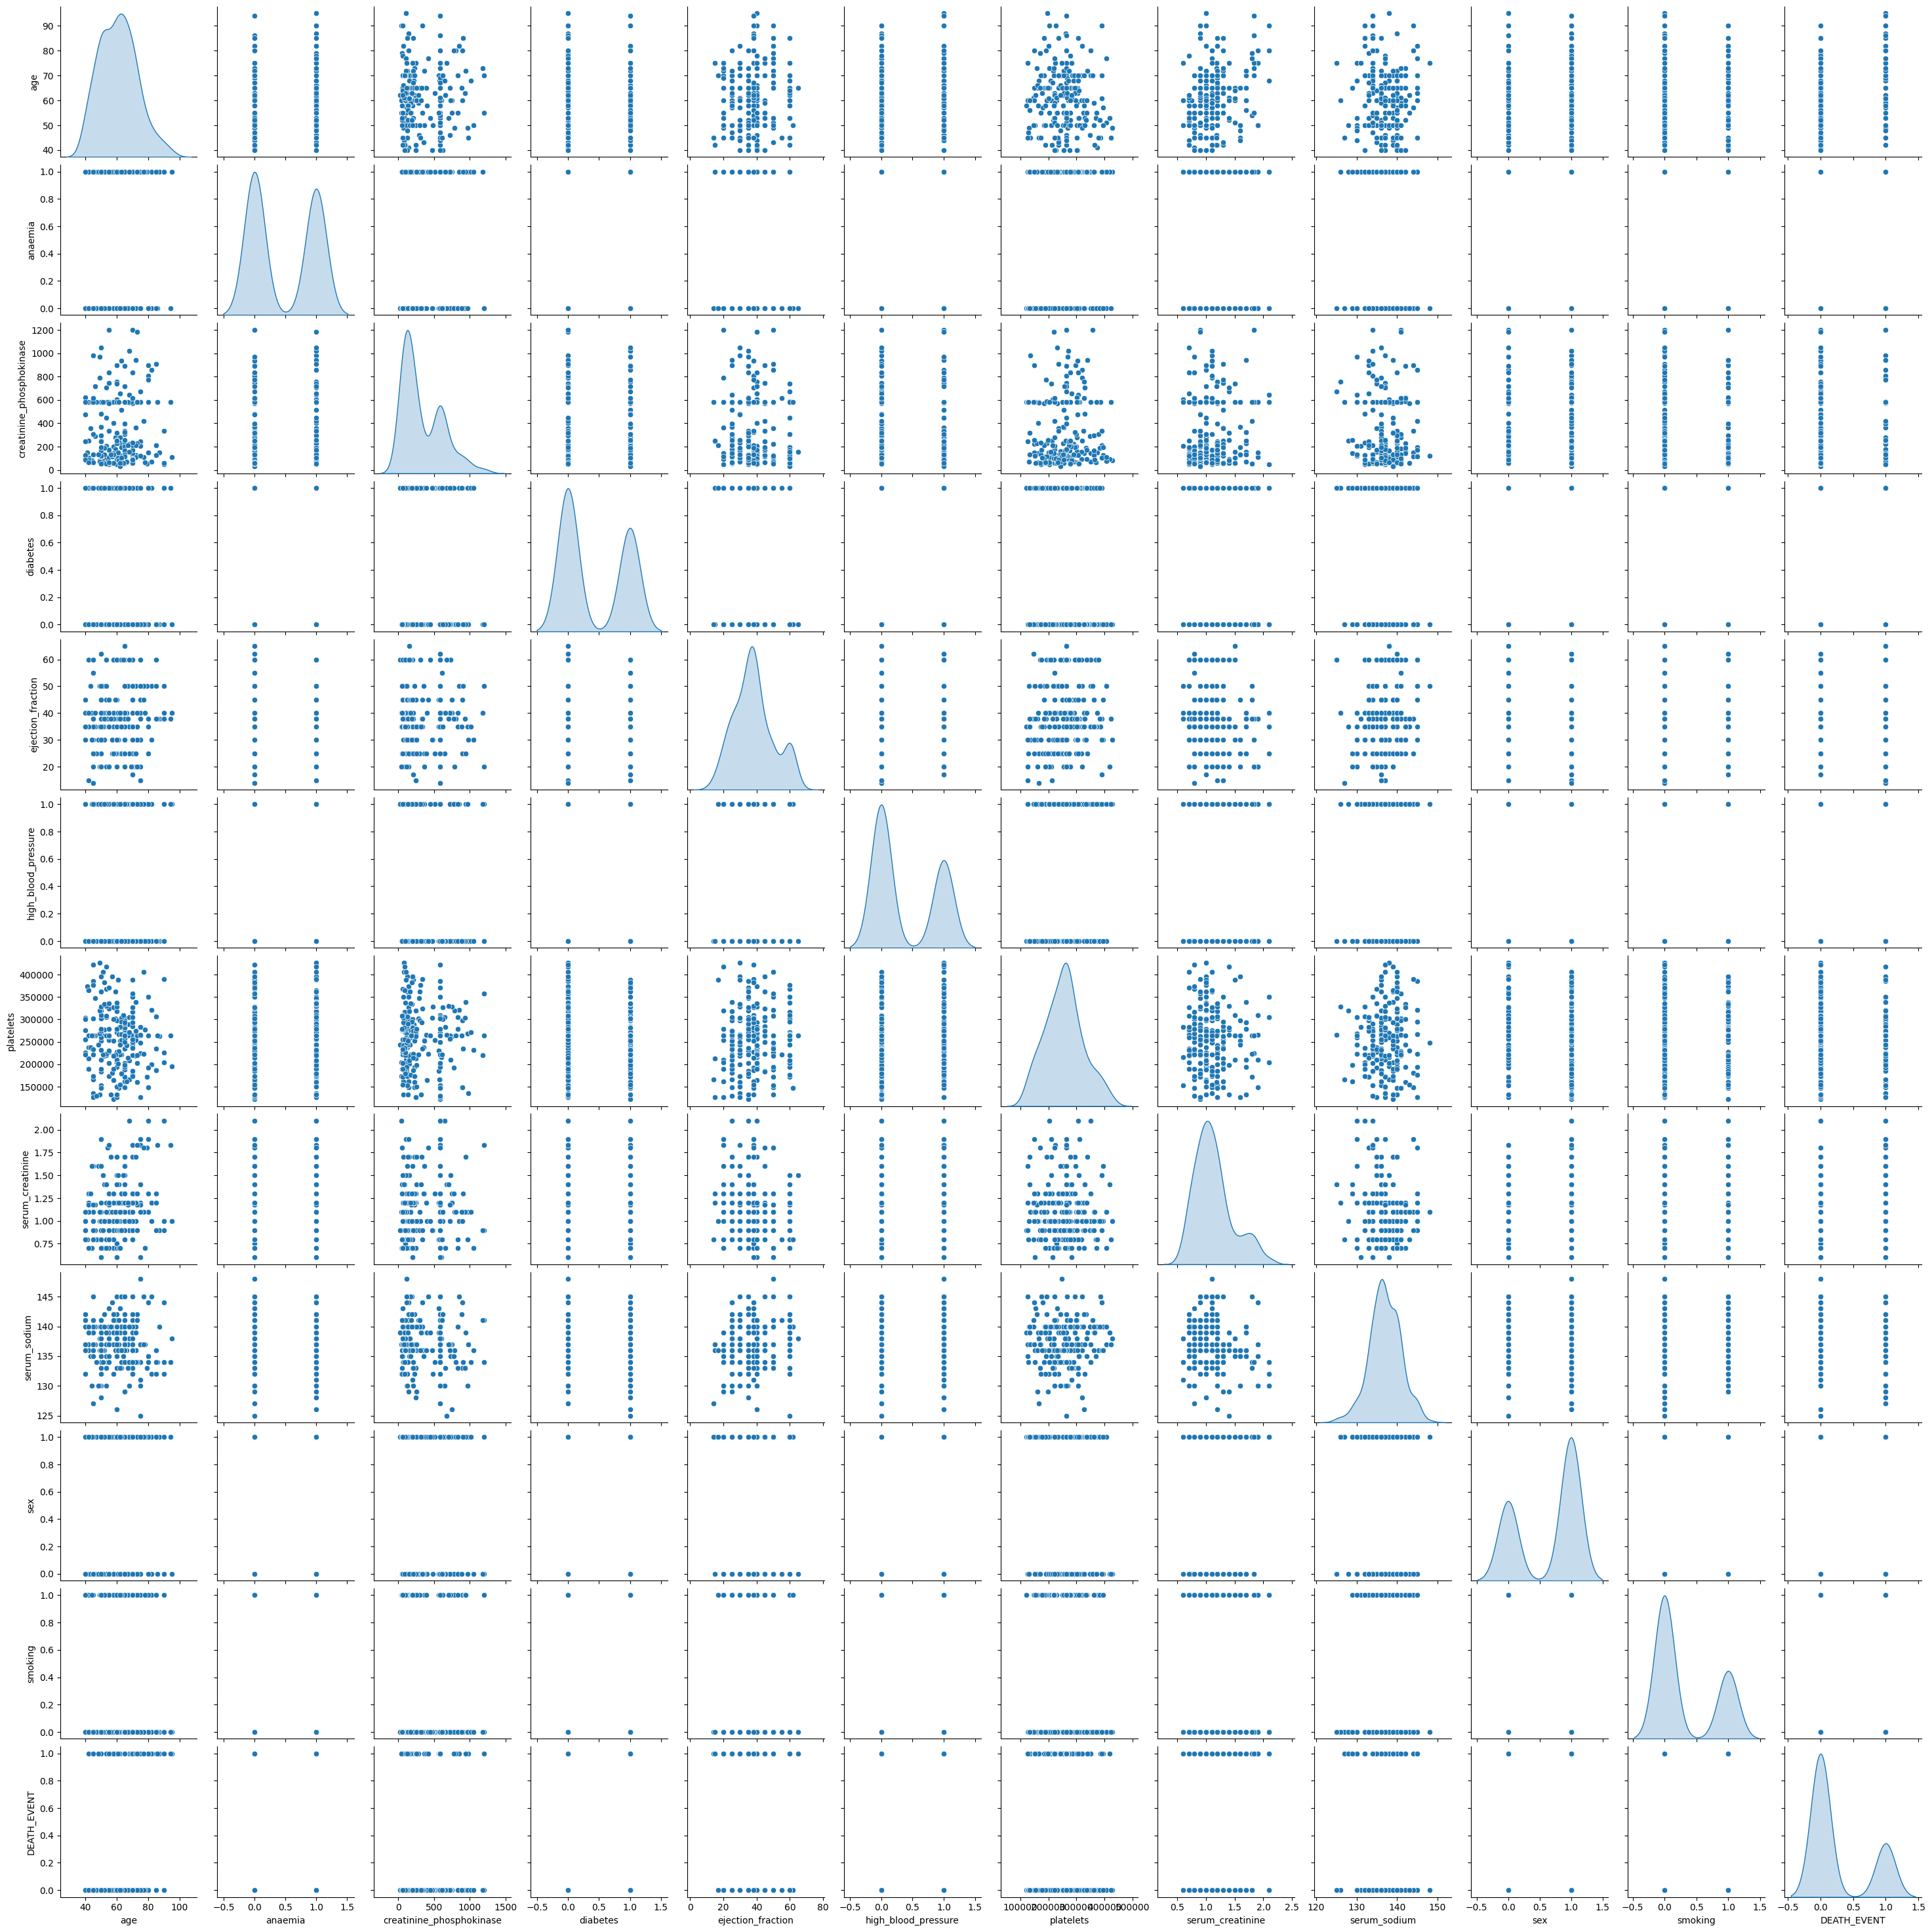

In [11]:
# Korrelierung der verschiedenen Merkmale miteinander
sns.pairplot(data=df,diag_kind='kde')

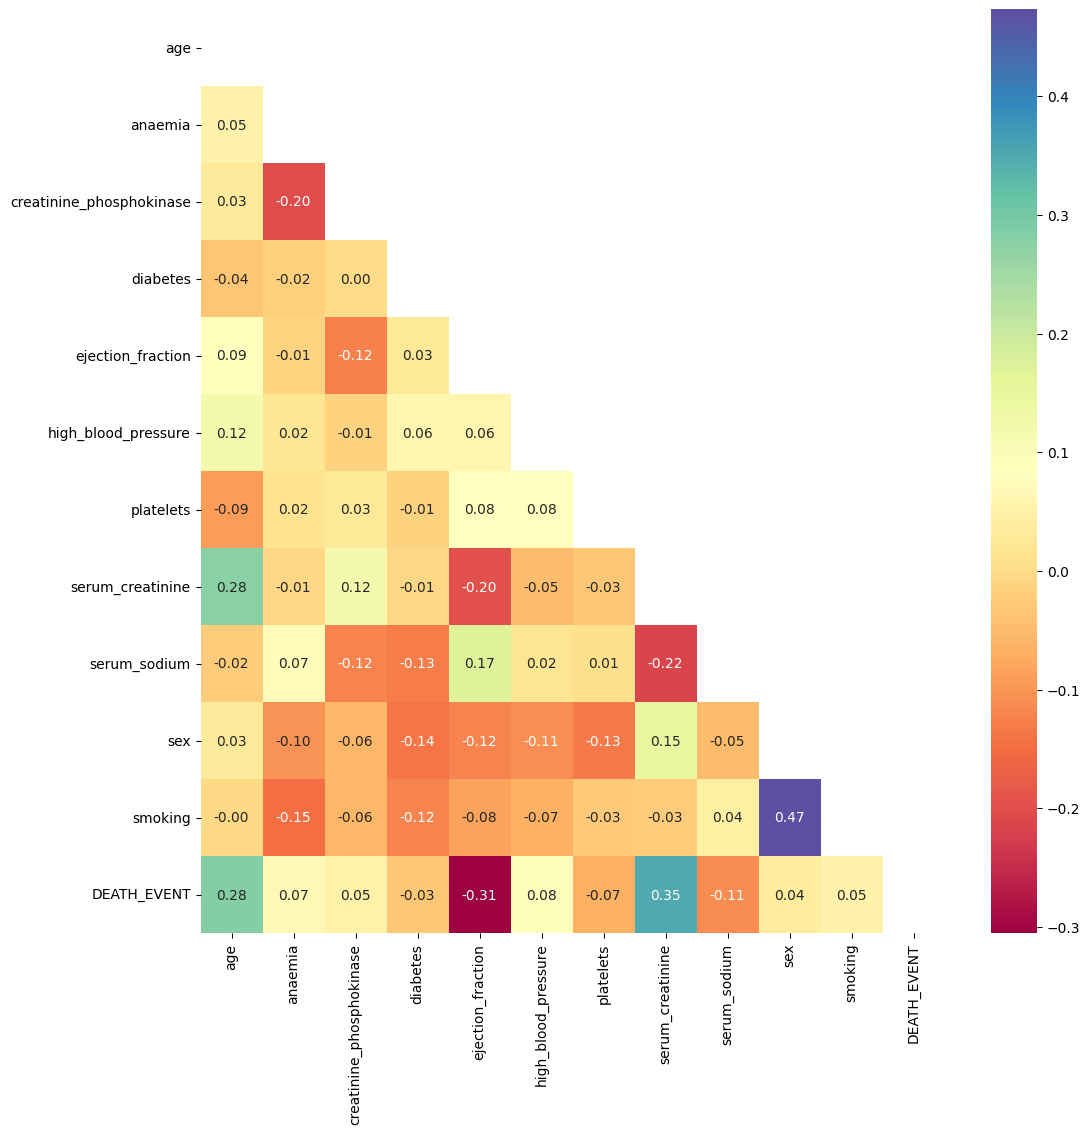

In [12]:
# Heatmap über die Abhängigkeit der verschiedenen Merkmale untereinander 
mask = np.triu(np.ones_like(df.corr(), dtype=bool))
plt.figure(figsize = (12, 12))
sns.heatmap(df.corr(), annot = True,  fmt=".2f", mask=mask, cmap="Spectral")
plt.show()

C:\Users\georg\AppData\Local\Temp\ipykernel_8776\269642667.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x="DEATH_EVENT", data=df, palette="Magma")


ValueError: 'Magma' is not a valid palette name

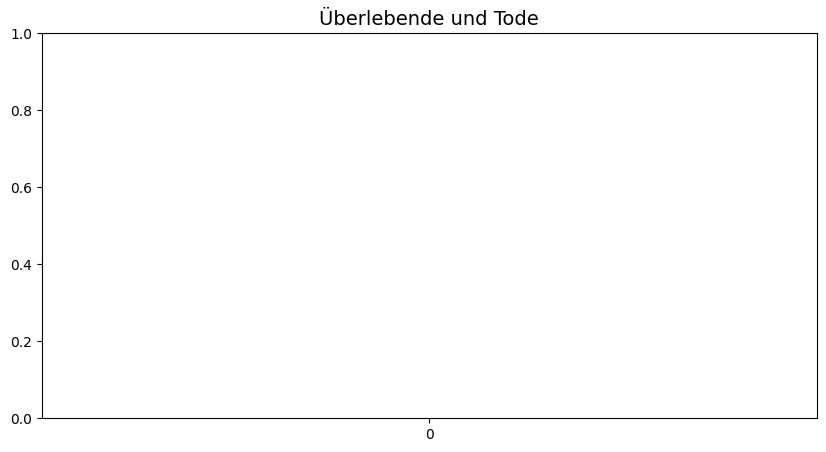

In [31]:
# Anzahl der Toten und Überlebenden im Datensatz
plt.figure(figsize=(10,5))
plt.title('Überlebende und Tode', fontsize=14)
sns.countplot(x="DEATH_EVENT", data=df, palette="Magma")
plt.xlabel("Zustand", fontsize=12)
plt.ylabel("Anzahl", fontsize=12)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

##### Bereinigung des Datensatzes

- es wird ein Scaler genutzt, um alle Eingangsvariablen auf eine einheitliche Skala zu bringen
- dies ist wichtig um große dominante Werte zu verhindern und die Effizienz der Modelle zu erhöhen (dieser können mit Werten in änhlichen Bereichen besser arbeiten)
- es gibt ebenfalls bestimmte Funktionen wie "sigmoid", die eine einheitliche Skala voraussetzen

In [14]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

sdf = scaler.fit_transform(df)
sdf = pd.DataFrame(sdf, columns=df.columns)

### A4 - Modellierung

## Artificial Neural Network (Till Wollschläger)

ANN, weil
- viele Features mit unterschiedlichen Datentypen
- ANN kann besser nicht-lineare Beziehungen zwischen den Features und der Zielvariable erkennen
- ANN erkennt selbst, welche Featues für die Vorhersage wichtig sind
    - Medizin ist ein sehr komplexes Thema -> erschwert Merkmalsextraktion, besonders für den medizinischen Leien

Problem ist allerdings die "geringe" Anzahl an Daten, das könnte zu Overfitting führen
-> es müssen Maßnahmen gegen Overfitting getroffen werden

In [15]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import numpy as np

In [16]:
from tensorflow import keras
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from tensorflow.keras.layers import Input
import seaborn as sns
from tensorflow.keras.callbacks import EarlyStopping
from imblearn.over_sampling import SMOTE
from tensorflow.keras.optimizers import Adam


In [17]:
X = sdf.drop(columns=["DEATH_EVENT"]).values
y = sdf["DEATH_EVENT"].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Smote wird genutzt, um zu versuchen, der einseitigen Vorhersage von "Überleben" entgegenzuwirken
smote = SMOTE(sampling_strategy=0.5, random_state=42)
X_train, y_train = smote.fit_resample(X_train, y_train)

model = keras.Sequential()

# gibt die Anzahl der Eingabe Features vor
model.add(Input(shape=(X_train.shape[1],)))

# Dropout, um Overfitting entgegenzuwirken
keras.layers.Dropout(0.2)

# L2-Regularisierung gegen Overfitting
model.add(Dense(32, activation='relu', kernel_regularizer=keras.regularizers.l2(0.01)))
keras.layers.Dropout(0.2)
model.add(Dense(16, activation ='relu', kernel_regularizer=keras.regularizers.l2(0.01)))
keras.layers.Dropout(0.2)
model.add(Dense(8, activation ='relu', kernel_regularizer=keras.regularizers.l2(0.01)))
keras.layers.Dropout(0.2)
# Reduzierung auf binären Wert
model.add(Dense(1, activation = 'sigmoid'))

optimizer = Adam(learning_rate=0.001)

 # Kompilieren des Modells
model.compile(optimizer=optimizer, loss="binary_crossentropy", metrics=["accuracy"])

In [18]:
# Early Stopping für bessere Generalisierung
early_stop = keras.callbacks.EarlyStopping(monitor="val_loss", patience=20, restore_best_weights=True)

# Modell trainieren
model1 = model.fit(X_train, y_train, epochs=300, batch_size=16, 
                    validation_data=(X_test, y_test), 
                    callbacks=[early_stop], verbose=1)

Epoch 1/300
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - accuracy: 0.6094 - loss: 1.1892 - val_accuracy: 0.7556 - val_loss: 1.1345
Epoch 2/300
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.6767 - loss: 1.1364 - val_accuracy: 0.7556 - val_loss: 1.0826
Epoch 3/300
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.6778 - loss: 1.0918 - val_accuracy: 0.7556 - val_loss: 1.0325
Epoch 4/300
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.6450 - loss: 1.0598 - val_accuracy: 0.7556 - val_loss: 0.9854
Epoch 5/300
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.6654 - loss: 1.0083 - val_accuracy: 0.7556 - val_loss: 0.9460
Epoch 6/300
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.6495 - loss: 0.9904 - val_accuracy: 0.7556 - val_loss: 0.9179
Epoch 7/300
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.6554 - loss: 0.9630 - val_accuracy: 0.7556 - val_loss: 0.8921
Epoch 8/300
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.6883 - loss: 0.9149 - val_accuracy: 0.7556 -

In [19]:
eval_loss, eval_accuracy = model.evaluate(X_test, y_test, verbose=False)
print("Modell accuracy: %.2f" % eval_accuracy)

Modell accuracy: 0.76


##### Modellergebnis
- Das künstliche neuronale Netz varriert zwischen einer Accuracy von 0,75 - 0,82
- Das Ergebnis ist für ein Studentenprojekt gut, könnte aber in der Praxis so nicht genutzt werden
- Die Vorteile eines neuronalen Netzes zeigen sich auf dem kleinen Datensatz nur bedingt, andere Modelle sind hier zu bevorzugen

##### Generalisierung, Overfitting, Underfitting
- Da durch die "geringe" Anzahl an Daten für das künstliche neuronale Netz Gefahr für Overfitting besteht, wurde diese zusätzlich mit mehreren Verfahren minimiert
    - Dropout zwischen den Neuronenknoten
    - L2-Regularisierung an den Knoten
    - Early-Stop um automatisch die beste Anzahl an Epochen zu finden

- Der Vergleich von der Accuracy bei den Trainings und Validierungsdaten schließt auf eine gute, aber auch verbesserungswürdige Generalisierung
- Underfitting ist sehr unwahrscheinlich (siehe auch nachfolgende Diagramme)
- Overfitting ist ein großes Problem, kann aber mit den oben genannten Methoden minimiert werden

## Gradient Boosting Tree (Georg Kresse)

Wahl Gradient Boosting:
- für die Verwendung bei nicht-linearen und komplexen Mustern ausgelegt 
- overfitting kann mit Anpassung der Hyperparameter verringert werde

In [20]:
from sklearn.ensemble import GradientBoostingClassifier

In [21]:
X_train_gb, X_test_gb, y_train_gb, y_test_gb = train_test_split(X, y, test_size=0.3, random_state=4)

In [22]:
# Modell erstellen
# n_iter_no_change und subsample zum bekämpfen des overfitting
model_gb = GradientBoostingClassifier(n_estimators=60, criterion='friedman_mse', learning_rate=0.1, random_state=35, max_depth=5, n_iter_no_change=8,  subsample=0.9)

# Modell trainieren
model_gb.fit(X_train_gb, y_train_gb)

# Vorhersagen auf Testdaten
y_pred_gb = model_gb.predict(X_test_gb)


In [23]:
print(f'Genauigkeit Gradient Boosting: {model_gb.score(X_test_gb, y_test_gb):.2f}')

Genauigkeit Gradient Boosting: 0.76


##### Modellergebnis
- Genauigkeit schwankt um 75%
- die wichtigsten Attribute sind ejection_fraction, age, platelets und serum_creatinine; sie tragen zu circa 85 % des Ergebnisses bei

#### Generalisierung, Overfitting, Underfitting
- Aufgrund seines Vorgehens ist der Algorithmus eher anfällig für Overfitting
- die verhältnismäßig geringe Anzahl an Daten erschwert die Validierung, da ein Anteil der Daten für die Überprüfung des Modells vorgehalten wird und so die bereits begrenzten Testdaten noch weiter reduziert werden
- Maßnahmen gegen Overfitting durch Hyperparameter: n_estimators angepasst, n_iter_no_change als Methode des "early stopping" eingebaut

### A5 - Visualisierung

### ANN

Zusammenfassung ANN:

In [24]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 32)                  │             384 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 16)                  │             528 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 8)                   │             136 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 1)                   │               9 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,173 (12.40 KB)

 Trainable params: 1,057 (4.13 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2,116 (8.27 KB)

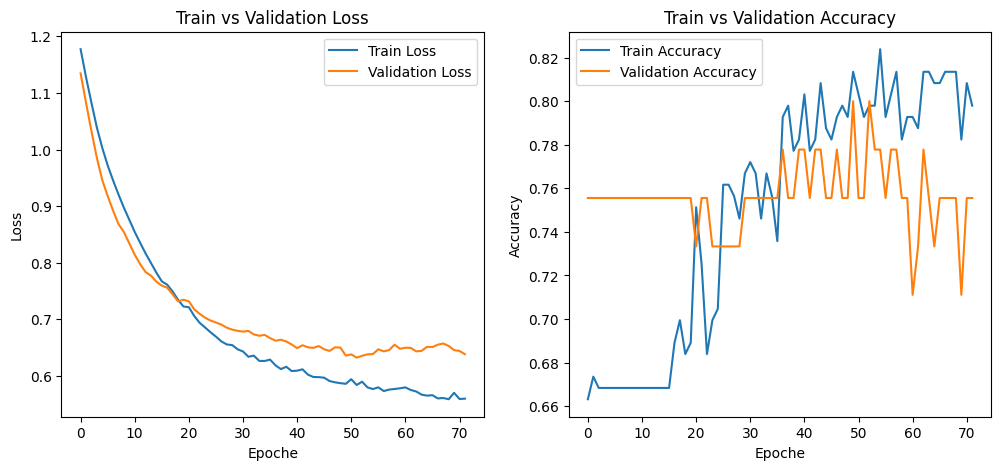

In [25]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(model1.history['loss'], label='Train Loss')
plt.plot(model1.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoche')
plt.ylabel('Loss')
plt.title('Train vs Validation Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(model1.history['accuracy'], label='Train Accuracy')
plt.plot(model1.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoche')
plt.ylabel('Accuracy')
plt.title('Train vs Validation Accuracy')
plt.legend()

plt.show()

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


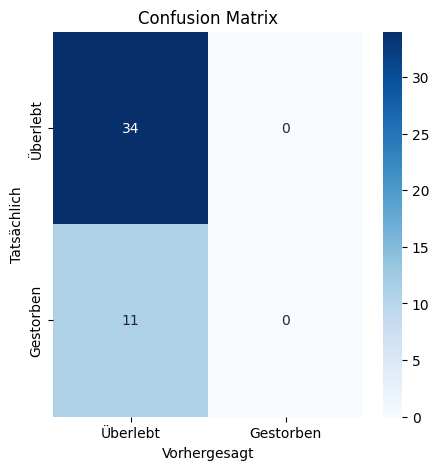

In [26]:
from sklearn.metrics import confusion_matrix, classification_report

y_pred = (model.predict(X_test) > 0.5).astype("int32")
y_pred_classes = np.argmax(y_pred, axis = 1)
y_pred_classes
cm = confusion_matrix(y_test, y_pred_classes)

plt.figure(figsize=(5,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Überlebt", "Gestorben"], yticklabels=["Überlebt", "Gestorben"])
plt.xlabel("Vorhergesagt")
plt.ylabel("Tatsächlich")
plt.title("Confusion Matrix")
plt.show()

### Gradient Boosting

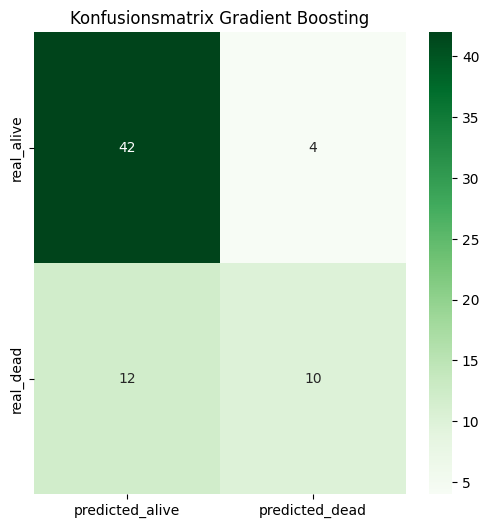

Klassifikationsbericht:
               precision    recall  f1-score   support

         0.0       0.78      0.91      0.84        46
         1.0       0.71      0.45      0.56        22

    accuracy                           0.76        68
   macro avg       0.75      0.68      0.70        68
weighted avg       0.76      0.76      0.75        68



In [27]:
# Konfusionsmatrix berechnen
cm_gb = confusion_matrix(y_test_gb, y_pred_gb)
# Konfusionsmatrix visualisieren
plt.figure(figsize=(6, 6))
plt.xlabel("Vorhergesagt")
plt.ylabel("Tatsächlich")
x_axis_labels = ['predicted_alive', 'predicted_dead'] # labels for x-axis
y_axis_labels = ['real_alive', 'real_dead'] # labels for y-axis
sns.heatmap(cm_gb, annot=True, fmt='d', cmap="Greens", xticklabels=x_axis_labels, yticklabels=y_axis_labels)
plt.title("Konfusionsmatrix Gradient Boosting")
plt.show()

# Klassifikationsbericht ausgeben
print("Klassifikationsbericht:\n", classification_report(y_test_gb, y_pred_gb))

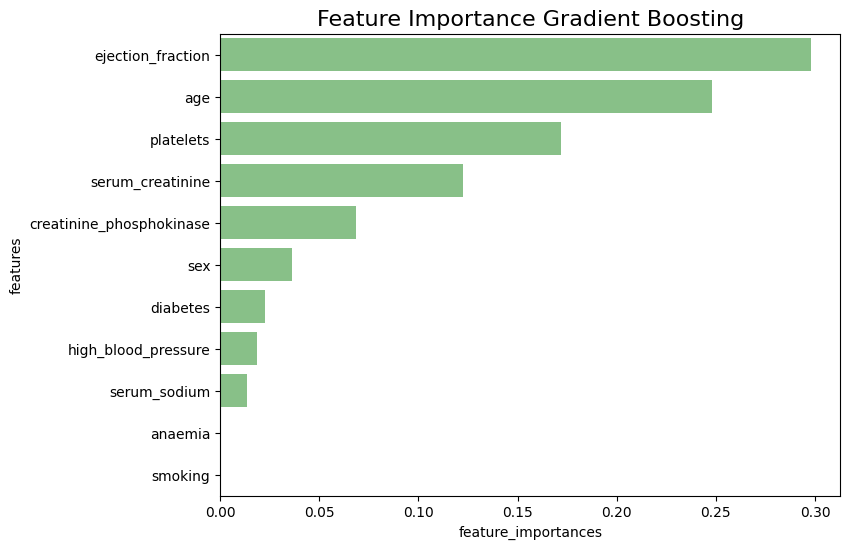

In [28]:
fi_df = pd.DataFrame({
    "feature_importances" : model_gb.feature_importances_,
    "features" : sdf.drop(columns=["DEATH_EVENT"]).columns
})

fi_df.sort_values(by="feature_importances", ascending=False, inplace=True)
sns.set_palette("Accent")
plt.figure(figsize=(8,6))
sns.barplot(x="feature_importances", y="features", data=fi_df)
plt.title("Feature Importance Gradient Boosting", fontsize=16)
plt.show()

In [29]:
feat_imp_dict = dict(zip(sdf.columns[:-1], model_gb.feature_importances_))

# Nach Wichtigkeit sortieren
sorted_feat_imp = sorted(feat_imp_dict.items(), key=lambda x: x[1], reverse=True)

# Top 4 Features
top_features = sorted_feat_imp[:4]

print("Anteile der Attribute am Ergebnis des Gradient Boosting Trees:")
for name, importance in top_features:
    print(f"{name}: {importance:.2%}")
print(f"Rest: {sum([imp[1] for imp in sorted_feat_imp[4:]]):.2%}")

Anteile der Attribute am Ergebnis des Gradient Boosting Trees:
ejection_fraction: 29.78%
age: 24.79%
platelets: 17.19%
serum_creatinine: 12.27%
Rest: 15.97%


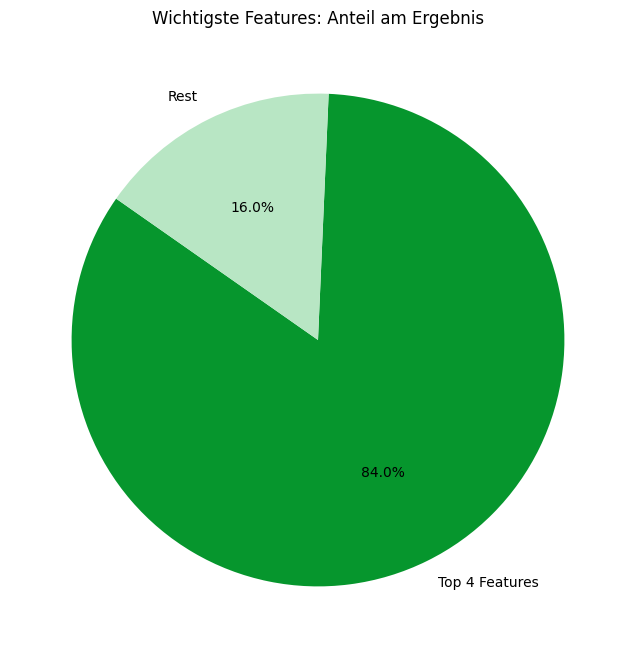

In [30]:
labels = ["Top 4 Features", "Rest"]
values = [sum([feat[1] for feat in top_features]),  sum([feat[1] for feat in sorted_feat_imp[4:]])]

# Piechart erstellen
plt.figure(figsize=(8, 8))
wedges, texts, autotexts = plt.pie(values, labels=labels, autopct="%1.1f%%", colors=["#06962d", "#b8e6c4"], startangle=145)
plt.title("Wichtigste Features: Anteil am Ergebnis")
plt.show()

### A6 - Zusammenfassung und verwendete Quellen

##### Zusammenfassung
- Die Daten zeigen 299 Patienten mit Herzproblemen
- Die Modelle sollen anhand der erhobenen Daten eine möglichst genau und generelle Vorhersage treffen, ob eine Person ihre Krankheit überlebt

Das neuronale Netz kommt auf eine relativ hohe Accuracy, hat aber deutlich Probleme auf dem kleinen Datensatz richtig zum Einsatz zu kommen. Es kämpft mit Overfitting auf der einen (siehe "Train vs Validation" Diagramme) und einer einseitigen Vorhersage von "Überleben" (siehe Confusion Matrix) auf der anderen Seite. Es kann festgestellt werden, dass ein neuronales Netz auf diesem Datensatz potentiell eher ungeignet ist. Die Vorteile können aufgrund des kleinen Datensatzes die Nachteile nicht überwiegen.

Der Gradient Boosting Tree liefert weniger Genauigkeit. Da dieser Algorithmus auch leicht zu Overfitting neigen kann, müssen präventive Maßnahmen dagegen getroffen werden (wie das Anpassen der Hyperparameter). Eine Verringerung des Overfittings ging meist mit einer Abnahme der Genauigkeit einher, weshalb eine gewisse Balance angestrebt wurde, die mit der Verwendung zusätzlicher Daten durchaus verbessert werden kann. 


##### Was leisten die Modelle?
- Das künstliche neuronale Netz varriert mit der Accuracy zwischen 0,75 und 0,82, trifft aber relativ einseitig eine "Überleben" Entscheidung
- Gradient Boosting liegt mit der Accuracy bei ca. 0,75 +/- 0,03
- bei der Vorhersage des Überlebens schneidet GBT besser ab als bei der Vorhersage der Tode


##### Vergleichen der Modelle
- ANN erzielt eine bessere Genauigkeit
- GBT ist besser in der Richtigbestimmung von Toden als das ANN
- Bei ANN handelt es sich um einen Unsupervised Learning Algorithmus, GBT ist ein Supervised Learning Algorithmus


##### Wie gut können die Modelle generalisieren
- Da das neuronale Netz mit vergleichsweise "wenig" Daten arbeiten muss, ist overfitting und eine fehlende Generalisierung ein ernst zu nehmendes Problem
- es wurde deshalb mit verschiedenen Methoden (early stopping, regularization und dropouts) versucht, overfitting entgegenzuwirken und die Fähigkeit zur Generalisierung zu erhöhen, trotzdem gibt es eine relativ einseitige Vorhersage von "Überleben"


##### Schwachstellen, Fehlereinflüsse und Verbesserungsvorschläge
- Um das neuronale Netz zu verbessern sind mehr Trainingsdaten immer Vorteilhaft
- In den Trainingsdaten gibt es deutlich mehr Überlebende als Tote, das neuronale Netz neigt daher (wie in der Confusion Matrix zu sehen) dazu eher Überleben als Tot vorauszusagen
- Mit SMOTE wurde bereits versucht, diesem Problem entgegenzuwirken. Eventuell sollte aber zusätzlich das Gewicht der einzelnen Knoten geändert werden.
- GBT weist eine vergleichsweise hohe Ungenauigkeit bei der Klassifizierung von Toden auf, dies ist (wie oben bereits angemerkt) unter anderem auf das ungleiche Verhältnis von Toden zu Überlebenden zurückzuführen
- das Attribut "time" wurde nicht verwendet

##### Quellen
- https://github.com/geoclaudsch/DASC-01-2025/ (Hauptquelle)
- https://www.kaggle.com/discussions/general/175912 (Techniques to prevent overfitting in Neural Networks)
- https://www.kaggle.com/datasets/rabieelkharoua/predict-survival-of-patients-with-heart-failure/discussion/498685 (Time is not a Feature, its a Target)
- https://imbalanced-learn.org/stable/references/generated/imblearn.over_sampling.SMOTE.html (SMOTE)
- https://www.tensorflow.org/ (alles mögliche zur Nutzung von TensorFlow)